# <span id="toc">  Esercizio 9 - Algoritmo Genetico </span>

- [Esercizio 9.1](#ex09_1)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import numpy as np

Il **problema del commesso viaggiatore (TSP)** consiste in un venditore e un insieme di $N$ città, ognuna con una posizione $\vec{c}_i$.
Il venditore deve visitare ciascuna città esattamente una volta, partendo da una città scelta e ritornando infine nella stessa città, con l’obiettivo di minimizzare la lunghezza totale del percorso.

Considerata una sequenza ordinata di città:
$$
\vec{c}_{i_1}, \vec{c}_{i_2}, \ldots, \vec{c}_{i_N}
$$

che rappresenta un cammino dal primo all’$N$-esimo punto, il costo del cammino può essere espresso come:

- Distanza euclidea al quadrato: $L^{(2)}(\vec{x}_1, \vec{x}_2, \ldots, \vec{x}_N) = \sum_{i=1}^N \left| \vec{x}_i - \vec{x}_{i+1} \right|^2$

- Distanza euclidea lineare: $L^{(1)}(\vec{x}_1, \vec{x}_2, \ldots, \vec{x}_N) = \sum_{i=1}^N \left| \vec{x}_i - \vec{x}_{i+1} \right|$

dove $\vec{x}_{N+1} = \vec{x}_1$ in modo da chiudere il ciclo.

Una particolare permutazione $P$ delle città $\{\vec{c}_1, \vec{c}_2, \ldots, \vec{c}_N\}$ genera un possibile cammino:

$$
\vec{x}_1, \vec{x}_2, \ldots, \vec{x}_N = \vec{c}_{P_1}, \vec{c}_{P_2}, \ldots, \vec{c}_{P_N}
$$

Per rappresentare questa permutazione, è sufficiente un vettore 1D che riporti l’ordine in cui le città vengono visitate.

Ad esempio, per $N=5$ città, una possibile soluzione è il vettore:

$$
[1, 3, 5, 4, 2]
$$

che corrisponde a partire dalla città $1$, poi visitare la $3$, la $5$, la $4$, la $2$ e infine ritornare alla $1$.

## <span id="ex09_1">  Esercizio 9.1 </span>[^](#toc)

L’obiettivo di questo esercizio è risolvere il TSP mediante un **Algoritmo Genetico (GA)**, che deve rispettare il vincolo che ciascuna città compaia una sola volta nella sequenza e che il cammino sia chiuso. 

Per inizializzare il GA è necessario generare una popolazione iniziale di $M$ "cromosomi", nel caso del TSP ciascuno di questi è una permutazione valida di città che definisce un cammino chiuso.
Il principio è far evolvere la popolazione nel tempo attraverso operatori che imitano selezione naturale, crossover e mutazioni, in modo da ottenere soluzioni via via migliori.

Ogni individuo viene valutato tramite una funzione di fitness che misura la bontà della soluzione, ottenuta a partire dal costo (nel mio caso ho scelto $L^{(2)}$), così che la popolazione venga ordinata sulla base di questo fitness.

Si scelgono due genitori dalla popolazione, privilegiando gli individui con fitness migliore tramite un operatore di selezione del tipo:  

$$
j = \text{int}(M \times r^{p_{sel}}) + 1
$$

dove $r$ è un numero casuale uniforme in $[0,1)$ e $p_{sel}$ è un esponente conveniente.

Una volta stabilito questo schema, si introducono alcuni operatori di mutazione genetica (mantenendo sempre fissa la prima città) per mantenere diversità nella popolazione, ad esempio:

- Permutazione di coppie di città, ad esempio $[1,2,3,4,5] \to [1,2,4,3,5]$.
- Traslazione di un blocco di $n$ posizioni per $m$ città contigue, con $m < N-1$, ad esempio $[1,2,3,4,5] \to [1,4,5,2,3]$ per una traslazione di +2 delle seconde e terze città.
- Permutazione tra due blocchi di $m$ città contigue, ad esempio $[1,2,3,4,5] \to [1,4,5,2,3]$ per lo scambio delle città $2-3$ con le città $4-5$.
- Inversione dell’ordine in cui appaiono le città all’interno di un blocco di lunghezza $m$ (con $m \leq N$), ad esempio $[1,2,3,4,5] \to [1,4,3,2,5]$ per l’inversione delle città da $2$ a $4$.

Ogni mutazione viene applicata con una certa probabilità $p_m^{(k)} < 10\%$.

Dai due genitori si generano nuovi individui figli combinando parti dei loro cromosomi, tramite un operatore di crossover con probabilità $p_{cross} > 50\%$, con lo scopo di esplorare nuove configurazioni che ereditino le caratteristiche migliori dei genitori.

I figli ottenuti (eventualmente mutati) vengono valutati e ordinati, quindi sostituiscono la popolazione precedente. 

### Algoritmo genetico

Nel codice che ho implementato, l’algoritmo genetico per il TSP è strutturato nei seguenti moduli:

- **Generazione delle città**  
  - `generate_circular_cities`: città distribuite uniformemente su una circonferenza.  
  - `generate_square_cities`: città distribuite uniformemente dentro un quadrato.

- **Cromosomi e fitness**  
  - `make_random_chromosome`: genera un cromosoma casuale valido fissando la città $1$.  
  - `evaluate_fitness`: calcola sia $L^{(1)}$ e sia $L^{(2)}$, defininendo la fitness come $1/L^{(2)}$.

- **Popolazione**  
  - `init_population`: genera una popolazione iniziale di percorsi casuali validi. 
  - `compare_chromosomes`: funzione di confronto per ordinare gli individui in base alla fitness.
  - `sort_population`: ordina gli individui per fitness (migliori davanti).

- **Selezione**  
  - `select_rank`: selezione basata sul rango.  
  - `select_two_parents`: scelta di due genitori distinti.

- **Mutazioni**  
  - `mutate_swap`: scambio di due città.  
  - `mutate_inversion`: inversione di un segmento.  
  - `mutate_shift`: traslazione di un blocco.  
  - `mutate_mpermut`: scambio di due blocchi di città.

- **Crossover**  
  - `crossover`: scambio di un segmento seguendo l’ordine del secondo genitore.

- **Evoluzione**  
  - `evolve_one_generation`: gestisce un’intera generazione, applicando selezione, crossover, mutazioni, validazione e ricalcolo della fitness.  
  
Alla fine dell’algoritmo è utile monitorare alcune quantità che permettono di valutare l’efficacia della ricerca e calibrare i parametri del GA:

- `best_length`: è la lunghezza del miglior percorso trovato nella popolazione. È il dato principale che misura direttamente la bontà della soluzione ottenuta dall’algoritmo.

- `avg_best_half_length`: è la media della lunghezza calcolata sulla metà migliore degli individui. Questa metrica fornisce informazioni sulla convergenza complessiva della popolazione. Se anche la media scende vicino al minimo, significa che non solo un singolo individuo ma gran parte della popolazione si è concentrata su soluzioni di buona qualità.

### Città sulla circonferenza

Ho applicato l’algoritmo genetico al caso di $34$ città distribuite uniformemente su una circonferenza di raggio unitario centrata nell’origine, scegliendo una popolazione di $M=1000$ individui e $G=500$ generazioni.

Durante l’evoluzione ho monitorato la lunghezza $L^{(1)}$ del miglior percorso e la media $\langle L^{(1)} \rangle$ della metà migliore della popolazione, entrambe in funzione del numero di generazioni.  

All'inzio della simulazione ho cercato di calibrare al meglio i parametri che controllano il GA, come la pressione selettiva data dall'esponente $p_{sel}$ che determina quanto i migliori individui vengono favoriti rispetto agli altri: valori troppo bassi portano a un’esplorazione lenta, mentre valori troppo alti rischiano di causare una convergenza prematura verso soluzioni non ottimali.

Per quanto riguarda le probabilità, quella di crossover come detto in precedenza deve essere $p_{cross} > 50\%$, mentre quelle di mutazione $p_m^{(k)} < 10\%$. Per queste ultime ho cercato di fissarle in modo tale che la loro somma fosse $\approx 15-20\%$.

```
2     p_sel
0.8   p_cross
0.06  p_m swap 
0.05  p_m inv
0.04  p_m shift
0.03  p_m mperm
```
In questo scenario è inoltre possibile stimare a priori l’ordine di grandezza della soluzione ottimale e quindi dell'efficacia dell'algoritmo, infatti il percorso migliore deve avvicinarsi alla lunghezza della circonferenza. 

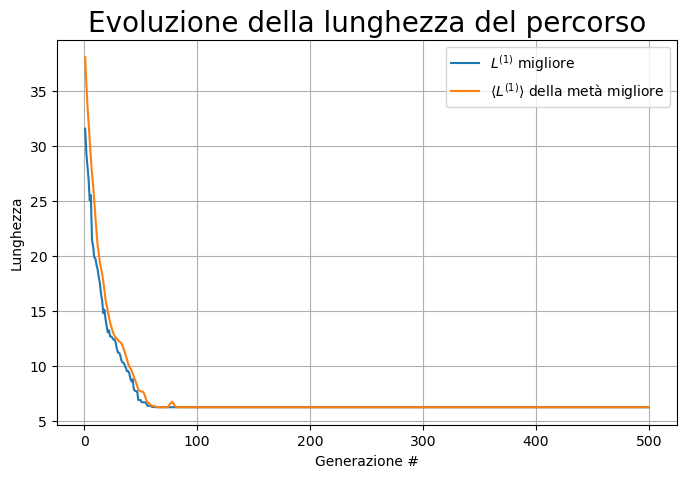

Valore minimo di L sul cerchio =  6.24306


In [2]:
# Lunghezza del percorso sulla circonferenza
plt.figure(figsize=(8,5))

gen, best = np.loadtxt('OUTPUT/circle/best_length.dat', skiprows=1, unpack=True)
gen, best_half = np.loadtxt('OUTPUT/circle/avg_best_half_length.dat', skiprows=1, unpack=True)

plt.plot(gen, best, label='$L^{(1)}$ migliore')
plt.plot(gen, best_half, label=r'$\langle L^{(1)} \rangle$ della metà migliore')
plt.xlabel('Generazione #', fontsize=10)
plt.ylabel('Lunghezza', fontsize=10)
plt.title('Evoluzione della lunghezza del percorso', fontsize=20)
plt.grid(True)
plt.legend()

plt.show()

print('Valore minimo di L sul cerchio = ', best[-1])


Dal grafico si osserva che l’algoritmo converge rapidamente al valore atteso $L \approx 2\pi$, entro un centinaio di generazioni. Inoltre la sovrapposizione tra il percorso migliore e la media della metà migliore mostra che l’intera popolazione si stabilizza sulla soluzione ottimale, il che indica che i parametri scelti in input sono adeguati per un problema di questo tipo.

Per visualizzare il risultato dell’algoritmo, è utile rappresentare le città in coordinate cartesiane e tracciare il percorso migliore trovato in diverse generazioni.
Nelle figure seguenti vengono mostrati i percorsi corrispondenti alla generazione iniziale e a quella finale.

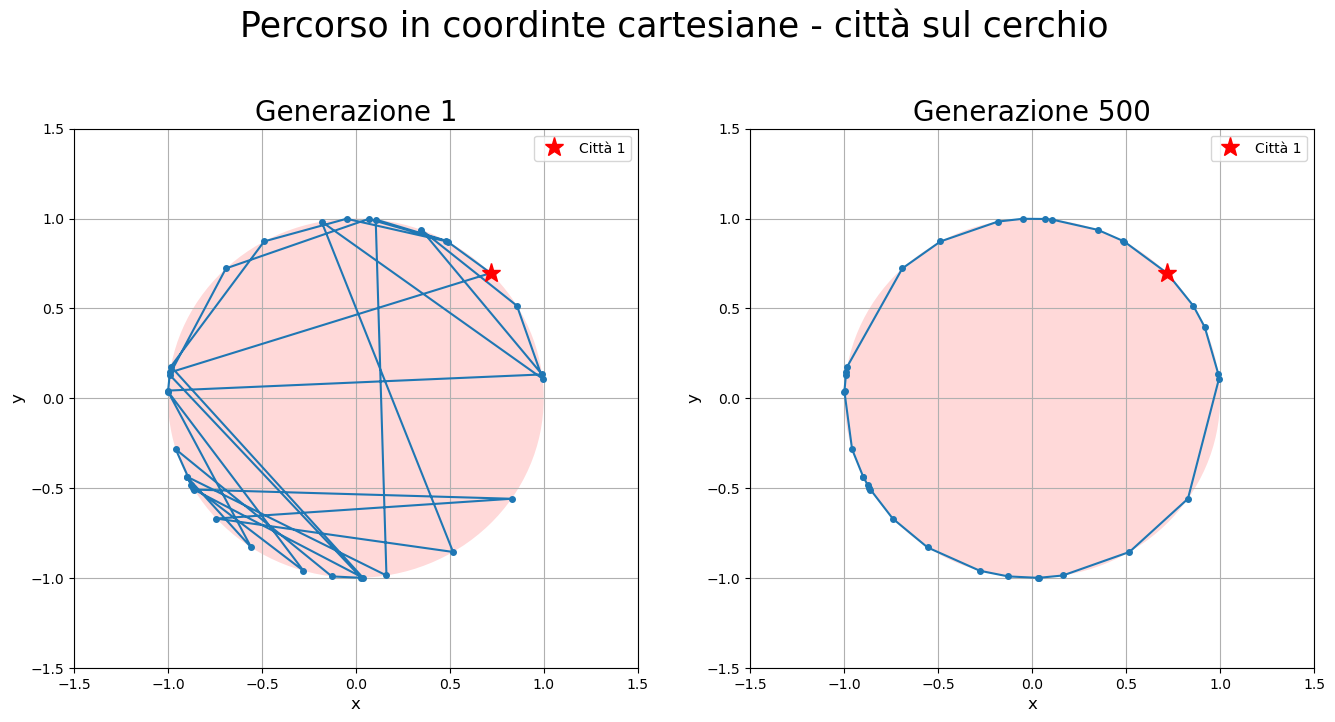

In [3]:
# Posizioni sulla circonferenza
plt.figure(figsize=(16,7))
plt.suptitle('Percorso in coordinte cartesiane - città sul cerchio', fontsize=25, y=1.05)

x, y = np.loadtxt('OUTPUT/circle/best_path.dat', skiprows=1, usecols=(1,2), unpack=True)
N = 34

# Generazione 1
plt.subplot(1,2,1)
x_0 = x[0:N-1]
y_0 = y[0:N-1]
plt.plot(np.r_[x_0, x_0[0]], np.r_[y_0, y_0[0]], marker='o', markersize=4)
plt.plot(x[0], y[0], marker='*', color='r', markersize=14, linestyle='', label='Città 1')
circle = plt.Circle((0,0), 1.0, fc='r', alpha=0.15)
plt.gca().add_patch(circle)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Generazione 1', fontsize=20)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()

# Generazione 500
plt.subplot(1,2,2)
x_f = x[-N:]
y_f = y[-N:]
plt.plot(np.r_[x_f, x_f[0]], np.r_[y_f, y_f[0]], marker='o', markersize=4)
plt.plot(x[0], y[0], marker='*', color='r', markersize=14, linestyle='', label='Città 1')
circle = plt.Circle((0,0), 1., fc='r', alpha=0.15)
plt.gca().add_patch(circle)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Generazione 500', fontsize=20)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()


plt.show()

All’inizio il cammino è completamente casuale, mentre dopo $500$ generazioni, il GA converge verso la soluzione attesa.
In quest'ultimo caso le città vengono percorse ordinatamente lungo la circonferenza, con un cammino regolare e senza intersezioni. 

Questo risultato conferma che il GA è stato in grado di ricostruire correttamente la soluzione ottimale, ovvero la disposizione circolare che corrisponde alla lunghezza minima del percorso.

### Città nel quadrato

Ho ripetuto l'analisi applicando l’algoritmo genetico al caso di 34 città distribuite uniformemente all’interno di un quadrato di lato 2 centrato nell’origine, scegliendo anche in questo caso una popolazione di $M=1000$ individui e $G=500$ generazioni.

Ho utilizzato gli stessi parametri del GA definiti in precedenza per $p_{sel}$, la probabilità di crossover $p_{cross}$ e le probabilità di mutazione $p_m^{(k)}$.

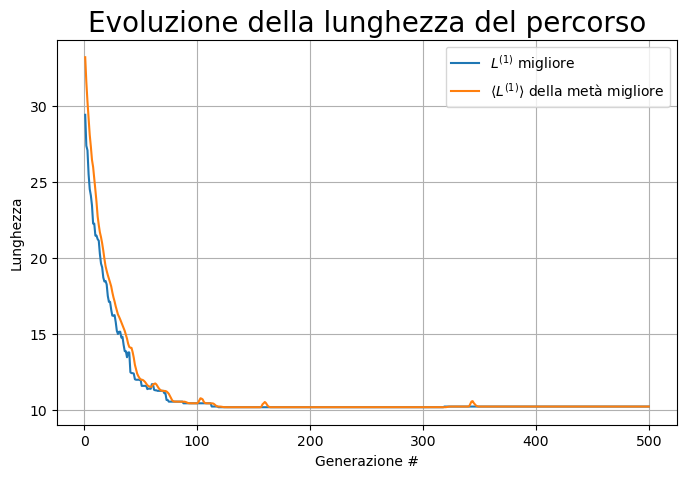

Valore minimo di L nel quadrato =  10.2004


In [4]:
# Lunghezza del percorso nel quadrato
plt.figure(figsize=(8,5))

gen, best = np.loadtxt('OUTPUT/square/best_length.dat', skiprows=1, unpack=True)
gen, best_half = np.loadtxt('OUTPUT/square/avg_best_half_length.dat', skiprows=1, unpack=True)

plt.plot(gen, best, label='$L^{(1)}$ migliore')
plt.plot(gen, best_half, label=r'$\langle L^{(1)} \rangle$ della metà migliore')
plt.xlabel('Generazione #', fontsize=10)
plt.ylabel('Lunghezza', fontsize=10)
plt.title('Evoluzione della lunghezza del percorso', fontsize=20)
plt.grid(True)
plt.legend()

plt.show()

print('Valore minimo di L nel quadrato = ', best[-1])


Dal grafico si osserva che anche in questo caso l’algoritmo converge entro $\approx 200$ generazioni ad un valore minimo, sia per il percorso migliore che per la media della metà migliore della popolazione.

Di seguito è riportato nuovamente un grafico che mostra l'evoluzione del percorso migliore in coordinate cartesiane, trovato in diverse generazioni.

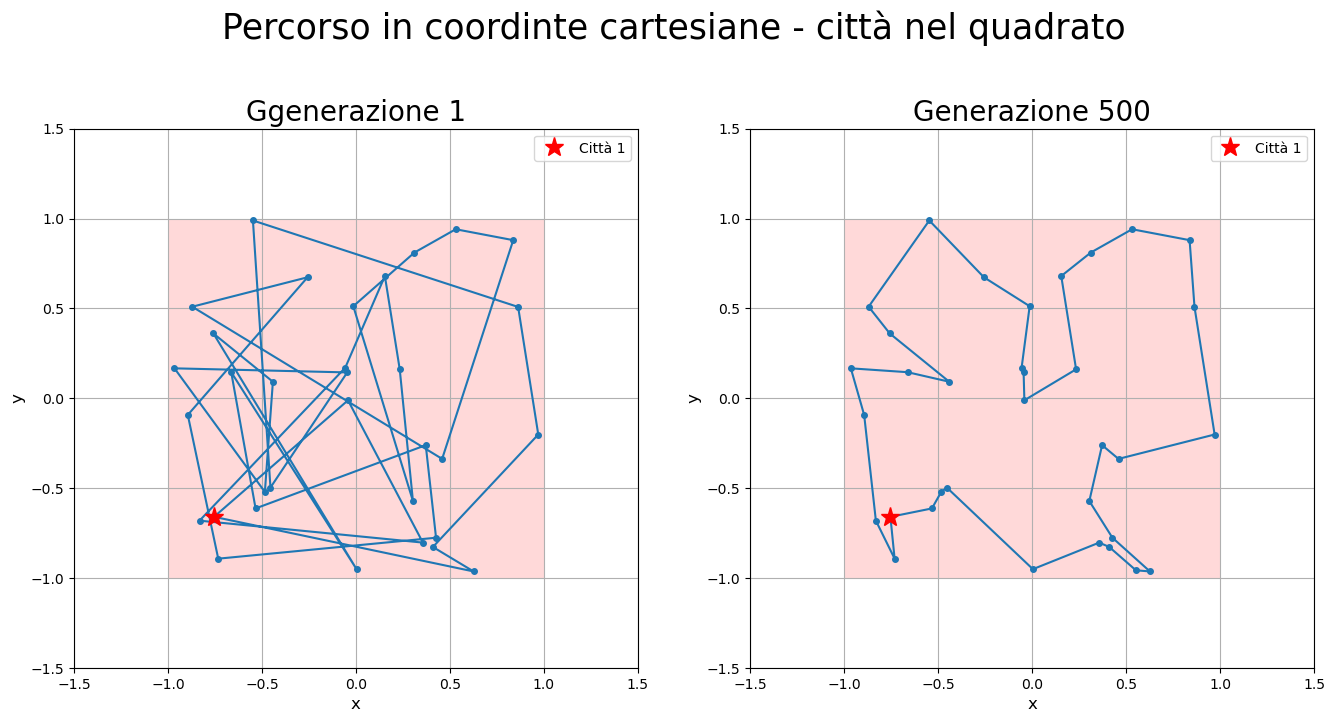

In [5]:
# Posizioni nel quadrato
plt.figure(figsize=(16,7))
plt.suptitle('Percorso in coordinte cartesiane - città nel quadrato', fontsize=25, y=1.05)

x, y = np.loadtxt('OUTPUT/square/best_path.dat', skiprows=1, usecols=(1,2), unpack=True)
N = 34

# Generazione 1
plt.subplot(1,2,1)
x_0 = x[0:N-1]
y_0 = y[0:N-1]
plt.plot(np.r_[x_0, x_0[0]], np.r_[y_0, y_0[0]], marker='o', markersize=4)
plt.plot(x[0], y[0], marker='*', color='r', markersize=14, linestyle='', label='Città 1')
square = Rectangle((-1,-1), 2, 2, fc='r', alpha=0.15)
plt.gca().add_patch(square)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Ggenerazione 1', fontsize=20)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()

# Generazione 500
plt.subplot(1,2,2)
x_f = x[-N:]
y_f = y[-N:]
plt.plot(np.r_[x_f, x_f[0]], np.r_[y_f, y_f[0]], marker='o', markersize=4)
plt.plot(x[0], y[0], marker='*', color='r', markersize=14, linestyle='', label='Città 1')
square = Rectangle((-1,-1), 2, 2, fc='r', alpha=0.15)
plt.gca().add_patch(square)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Generazione 500', fontsize=20)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()


plt.show()

Nel caso delle città distribuite nel quadrato non è possibile conoscere a priori quale sia il percorso ottimale, a differenza del caso sul cerchio.
Tuttavia, il risultato ottenuto dopo $500$ generazioni suggerisce che il GA sia riuscito a convergere verso una soluzione vicina al percorso ottimale.